In [117]:
import asyncio
import websockets
import json


class DeribitWS:

    def __init__(self, client_id, client_secret, live=False):

        if not live:
            self.url = 'wss://test.deribit.com/ws/api/v2'
        elif live:
            self.url = 'wss://www.deribit.com/ws/api/v2'
        else:
            raise Exception('live must be a bool, True=real, False=paper')


        self.client_id = client_id
        self.client_secret = client_secret

        self.auth_creds = {
              "jsonrpc" : "2.0",
              "id" : 0,
              "method" : "public/auth",
              "params" : {
                "grant_type" : "client_credentials",
                "client_id" : self.client_id,
                "client_secret" : self.client_secret
              }
            }
        self.test_creds()

        self.msg = {
            "jsonrpc": "2.0",
            "id": 0,
            "method": None,
        }

    async def pub_api(self, msg):
        async with websockets.connect(self.url) as websocket:
            await websocket.send(msg)
            while websocket.open:
                response = await websocket.recv()
                return json.loads(response)

    async def priv_api(self, msg):
        async with websockets.connect(self.url) as websocket:
            await websocket.send(json.dumps(self.auth_creds))
            while websocket.open:
                response = await websocket.recv()
                await websocket.send(msg)
                response = await websocket.recv()
                break
            return json.loads(response)

    @staticmethod
    def async_loop(api, message):
        return asyncio.get_event_loop().run_until_complete(api(message))

    def test_creds(self):
        response = self.async_loop(self.pub_api, json.dumps(self.auth_creds))
        if 'error' in response.keys():
            raise Exception(f"Auth failed with error {response['error']}")
        else:
            print("Authentication success")

    def market_order(self, instrument, amount, direction):
        params = {
                "instrument_name" : instrument,
                "amount" : amount,
                "type" : "market",
              }

        if direction.lower() == 'long':
            side = 'buy'
        elif direction.lower() == 'short':
            side = 'sell'
        else:
            raise ValueError('direction must be long or short')

        self.msg["method"] = f"private/{side}"
        self.msg["params"] = params

        response = self.async_loop(self.priv_api, json.dumps(self.msg))

        return response


    def limit_order(self, instrument, amount, direction, price,
                   post_only, reduce_only):
        params = {
            "instrument_name": instrument,
            "amount": amount,
            "type": "limit",
            "price": price,
            "post_only":  post_only,
            "reduce_only": reduce_only

        }
        if direction.lower() == 'long':
            side = 'buy'
        elif direction.lower() == 'short':
            side = 'sell'
        else:
            raise ValueError('direction must be long or short')

        self.msg["method"] = f"private/{side}"
        self.msg["params"] = params
        response = self.async_loop(self.priv_api, json.dumps(self.msg))
        return response

    # market data methods
    def get_data(self, instrument, start, end, timeframe):
        params =  {
                "instrument_name": instrument,
                "start_timestamp": start,
                "end_timestamp": end,
                "resolution": timeframe
            }

        self.msg["method"] = "public/get_tradingview_chart_data"
        self.msg["params"] = params

        data = self.async_loop(self.pub_api, json.dumps(self.msg))
        return data

    def get_orderbook(self, instrument, depth=5):
        params = {
            "instrument_name": instrument,
            "depth": depth
        }
        self.msg["method"] = "public/get_order_book"
        self.msg["params"] = params

        order_book = self.async_loop(self.pub_api, json.dumps(self.msg))
        return order_book

    def get_quote(self, instrument):
        params = {
            "instrument_name": instrument
        }
        self.msg["method"] = "public/ticker"
        self.msg["params"] = params
        quote = self.async_loop(self.pub_api, json.dumps(self.msg))

        return quote['result']['last_price']

    #account methods
    def account_summary(self, currency, extended=True):
        params = {
            "currency": currency,
            "extended": extended
        }

        self.msg["method"] = "private/get_account_summary"
        self.msg["params"] = params
        summary = self.async_loop(self.priv_api, json.dumps(self.msg))
        return summary

    def get_positions(self, currency, kind="option"):
        params = {
            "currency": currency,
            "kind": kind
        }
        self.msg["method"] = "private/get_positions"
        self.msg["params"] = params
        positions = self.async_loop(self.priv_api, json.dumps(self.msg))
        return positions

    def available_instruments(self, currency, kind="future", expired=False):
        params = {
            "currency": currency,
            "kind": kind,
            "expired": expired
        }

        self.msg["method"] = "public/get_instruments"
        self.msg["params"] = params
        resp = self.async_loop(self.pub_api, json.dumps(self.msg))
        instruments = [d["instrument_name"] for d in resp['result']]
        return instruments
    


    def get_trade_hist(self,currency,count = 10):
        params={
            'currency':currency,
            'count':count
        }
        self.msg['method'] = "private/get_trigger_order_history"
        self.msg['params']=params
        resp = self.async_loop(self.priv_api, json.dumps(self.msg))

        return resp



In [1]:
import pandas as pd
import numpy as np
import os

import
os.getcwd()

SyntaxError: invalid syntax (1870214629.py, line 5)

In [ ]:
creds = pd.read_csv(r'C:\Users\kmavy\OneDrive\Desktop\credentials.csv')

In [ ]:
client_id = creds['client_id'].values[0]
client_secret =creds['client_secret'].values[0]

ws = DeribitWS(client_id=client_id, client_secret=client_secret, live=True)

NameError: name 'DeribitWS' is not defined

In [ ]:
ws.get_positions(currency='ETH')['result']

[{'floating_profit_loss_usd': -12.387627,
  'average_price_usd': 16.418305,
  'total_profit_loss': -0.00513927,
  'realized_profit_loss': 0.0,
  'floating_profit_loss': 0.001974089,
  'average_price': 0.005875,
  'theta': -3.24743,
  'vega': 3.77303,
  'gamma': 0.00062,
  'delta': -0.18833,
  'open_orders_margin': 0.0,
  'initial_margin': 0.0,
  'maintenance_margin': 0.0,
  'settlement_price': 0.004097,
  'instrument_name': 'ETH-29MAR24-2100-P',
  'mark_price': 0.00459,
  'index_price': 2902.15,
  'direction': 'buy',
  'kind': 'option',
  'size': 4.0},
 {'floating_profit_loss_usd': 21.898604,
  'average_price_usd': 32.123235,
  'total_profit_loss': 0.009270563,
  'realized_profit_loss': 0.0,
  'floating_profit_loss': -0.00380472,
  'average_price': 0.0115,
  'theta': 4.99097,
  'vega': -6.26141,
  'gamma': -0.0011,
  'delta': 0.36218,
  'open_orders_margin': 0.0,
  'initial_margin': 0.436729436,
  'maintenance_margin': 0.336729436,
  'settlement_price': 0.008231,
  'instrument_name': '

In [ ]:
pd.DataFrame(ws.account_summary('ETH',extended=False)['result']).columns

Index(['projected_delta_total', 'available_withdrawal_funds', 'margin_balance',
       'options_session_upl', 'options_value', 'total_pl',
       'projected_initial_margin', 'projected_maintenance_margin', 'equity',
       'options_gamma', 'futures_pl', 'maintenance_margin',
       'portfolio_margining_enabled', 'futures_session_rpl', 'currency',
       'options_vega', 'session_rpl', 'options_session_rpl',
       'options_theta_map', 'additional_reserve', 'cross_collateral_enabled',
       'available_funds', 'margin_model', 'initial_margin', 'options_vega_map',
       'delta_total', 'options_theta', 'fee_balance', 'spot_reserve',
       'session_upl', 'delta_total_map', 'deposit_address',
       'options_gamma_map', 'balance', 'options_delta', 'options_pl', 'limits',
       'futures_session_upl'],
      dtype='object')

In [ ]:
pd.DataFrame(ws.account_summary('ETH',extended=False)['result'])[['options_pl']]

,options_pl
eth_usd,-0.010426
non_matching_engine,-0.010426
matching_engine,-0.010426


In [ ]:
-0.0105*2800

-29.400000000000002

In [2]:
pd.DataFrame(ws.account_summary('ETH',extended=False)['result'])[['total_pl']]

NameError: name 'pd' is not defined

In [ ]:
ws.get_positions(instrument='ETH')

{'jsonrpc': '2.0',
 'id': 0,
 'error': {'message': 'Invalid params',
  'data': {'param': 'currency', 'reason': 'value required'},
  'code': -32602},
 'usIn': 1708354861337483,
 'usOut': 1708354861337602,
 'usDiff': 119,
 'testnet': False}

In [17]:
import numpy as np

In [41]:
((1)/(1+prev_rets))-1

PnL    0.036887
dtype: float64

In [46]:
import pandas as pd
import numpy as np
import nest_asyncio
nest_asyncio.apply()
import account_mgmt as accmgmt
import csv
import os

creds = pd.read_csv(r'C:\Users\kmavy\OneDrive\Desktop\credentials.csv')

client_id = creds['client_id'].values[0]
client_secret =creds['client_secret'].values[0]

ws = accmgmt.DeribitWS(client_id=client_id, client_secret=client_secret, live=True)
positions = ws.get_positions(currency='ETH')['result']
pnl,delta,vega,theta,gamma = 0,0,0,0,0


perf_path =os.path.join(os.getcwd(),'performance_analytics\\perf_analytics.csv') 
greeks_path = os.path.join(os.getcwd(),'performance_analytics\\portfolio_greeks.csv') 

rets = pd.read_csv(r'performance_analytics\\perf_analytics.csv',index_col = 0)
prev_rets = (1+rets).prod()-1
dep = float(input())
c=1
ret=0
for dets in positions:
    print(f"Position {dets['direction']} {dets['instrument_name']} PnL:",dets['floating_profit_loss_usd'])
    ret+=(dets['floating_profit_loss_usd']+dets['realized_profit_loss'])
    ret = ret/dep
    ret = ((1+ret)/(1+prev_rets))-1
    delta +=dets['delta']
    theta +=dets['theta']
    vega +=dets['vega']
    gamma+=dets['gamma']
    c+=1

print('''


''')

shortvolpnl = pd.DataFrame([ret[0]],index = [pd.datetime.today().strftime("%Y-%m-%d")],columns = ['daily_pnl'])
portfolio_greeks = pd.DataFrame(np.array([delta,vega,theta,gamma]).reshape(-1,4),index = [pd.datetime.today().strftime("%Y-%m-%d")],columns = ['delta','vega','theta','gamma'])



with open(perf_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(shortvolpnl)):
        temp = shortvolpnl.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()



with open(greeks_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(portfolio_greeks)):
        temp = portfolio_greeks.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()

Authentication success
Position buy ETH-29MAR24-2100-P PnL: -15.905918
Position sell ETH-29MAR24-2300-P PnL: 33.170194
Position sell ETH-29MAR24-2500-P PnL: 7.064134
Position sell ETH-29MAR24-3300-C PnL: -46.581169
Position sell ETH-29MAR24-3400-C PnL: 23.349456
Position buy ETH-29MAR24-3500-C PnL: -0.258817
Position sell ETH-8MAR24-2500-P PnL: 6.389391
Position sell ETH-8MAR24-3400-C PnL: 19.012429






C:\Users\kmavy\AppData\Local\Temp\ipykernel_24704\2523835252.py:43: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  shortvolpnl = pd.DataFrame([ret[0]],index = [pd.datetime.today().strftime("%Y-%m-%d")],columns = ['daily_pnl'])
C:\Users\kmavy\AppData\Local\Temp\ipykernel_24704\2523835252.py:44: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  portfolio_greeks = pd.DataFrame(np.array([delta,vega,theta,gamma]).reshape(-1,4),index = [pd.datetime.today().strftime("%Y-%m-%d")],columns = ['delta','vega','theta','gamma'])


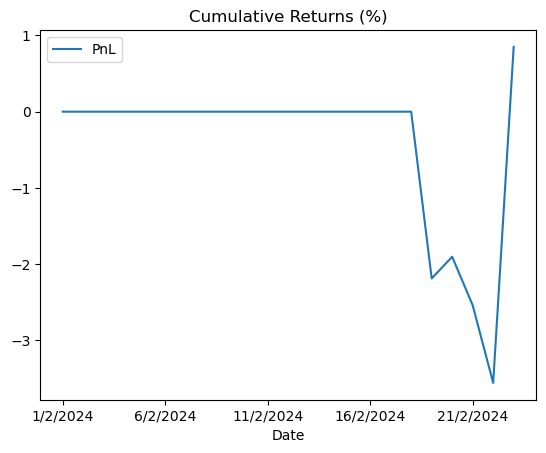

In [47]:

rets = pd.read_csv(r'performance_analytics\\perf_analytics.csv',index_col = 0)
rets = rets[~rets.index.duplicated(keep='last')]
pic = (((1+rets).cumprod()-1)*100).plot(title = 'Cumulative Returns (%)').get_figure()
pic.savefig('CumulativePerformance.png')